In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically

# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load modules related to this exercise
import tools 
from model_dc_multidim import model_dc_multidim
import egm_dc_multidim as egm
import time
import random

In [2]:
egm.pens_fun(1001, 0)

8.19590192686237

In [3]:
def marg_pens(m, wage):
    v = 0.1
    return -(0.00499 * np.exp((0.00499 * m + 10.75973 - 0.00499 * 117.08260)/v) ) / ( ( np.exp(0.00499 * (m - 117.08260)/v ) + np.exp(0.27749 * wage/v) + np.exp(10.75973/v) +1)  * (np.exp(0.00499 *(m - 117.08260)/v ) + np.exp(wage * 0.27749/v) +1 ) )

marg_pens(1000, 0)

-0.004989999999999929

In [4]:
model = model_dc_multidim()
model.setup()
model.create_grids()

In [5]:
t0 = time.time()  # set the starting time
model = model_dc_multidim()
model.setup()
model.create_grids()
model.solve()
t1 = time.time() # set the ending time
print(f'time: {t1-t0:.8} seconds') # print the total time

Evalutating: cg, low
Evalutating period: 88
Evalutating period: 87
Evalutating period: 86
Evalutating period: 85
Evalutating period: 84
Evalutating period: 83
Evalutating period: 82
Evalutating period: 81
Evalutating period: 80
Evalutating period: 79
Evalutating period: 78
Evalutating period: 77
Evalutating period: 76
Evalutating period: 75
Evalutating period: 74
Evalutating period: 73
Evalutating period: 72
Evalutating period: 71
Evalutating period: 70
Evalutating period: 69
Evalutating period: 68
Evalutating period: 67
Evalutating period: 66
Evalutating period: 65
Evalutating period: 64
Evalutating period: 63
Evalutating period: 62
Evalutating period: 61
Evalutating period: 60
Evalutating period: 59
Evalutating period: 58
Evalutating period: 57
Evalutating period: 56
Evalutating period: 55
Evalutating period: 54
Evalutating period: 53
Evalutating period: 52
Evalutating period: 51
Evalutating period: 50
Evalutating period: 49
Evalutating period: 48
Evalutating period: 47
Evalutating p

In [6]:
m = np.array([15,15], dtype = float)
e = np.array([1,1], dtype=float)
par = model.par
sol = model.sol
c = tools.interp_2d_vec(par.grid_m, par.grid_e, sol.c[30, 0, :, :, 0, 0],m,e)
c

array([16.62151476, 16.62151476])

In [32]:
np.random.seed(100)
def pens_fun(m, wage):
    year = 2015
    m_asset_test = m
    pens = soft_max(10.75973 + 1.84692 * (year > 2010) 
                    - soft_max(0, soft_max(0.27749 * wage, 0.00499 * (m_asset_test - 117.08260))), 0)
    return pens

def tax_fun(income, par):
    thld_1 = 17.3918
    thld_2 = 73.1766

    if income < thld_1:
        return 0 * income
    if income < thld_2:
        return 0.29907 * (income - thld_1)
    return 0.37930 * (income - thld_2) + 0.29907 * thld_2

def human_capital(e, t, par, tau=("cg","high")):
    edu, skill = tau
    t -= 20
    return np.exp(par.eta_0[edu] + par.eta_0[skill] + par.eta_1[edu] * t*e + par.eta_2[edu] * (t*e)**2 + par.eta_3*t + par.eta_4*t**2)

def soft_max(x, y):
    v = 0.4
    return v * np.log(np.exp(x/v) + np.exp(y/v))

def pens_fun(m, wage):
    year = 2015
    m_asset_test = m
    pens = soft_max(10.75973 + 1.84692 * (year > 2010) 
                    - soft_max(0, soft_max(0.27749 * wage, 0.00499 * (m_asset_test - 117.08260))), 0)
    return pens

def res(V, sigma):
    # Maximum over the discrete choices (0 = for each column, i.e., for each "competing choice")
    mxm = V.max(0)
    # numerically robust log-sum
    log_sum = mxm + sigma*(np.log(np.sum(np.exp((V - mxm) / sigma),axis=0)))
    prob = np.exp((V- log_sum) / sigma)    
    return prob    

def simulate (model):
    par = model.par
    sol = model.sol
    sim = model.sim
    
    par.simN = 1000
    par.simT = par.T
    par.Tmin = 25
    
    num_high = int(par.simN * model.par.high_proportion["cg"]) # numbers of high type in simulation rounded
    num_in_sim = {"high": (0, num_high), "low": (num_high, par.simN)}
    
    # Initialize
    #par.simN = simN
    shape = (par.simT, par.simN)
    sim.m = np.nan +np.zeros(shape)
    sim.c = np.nan +np.zeros(shape)
    sim.a = np.nan +np.zeros(shape)
    sim.e = np.nan +np.zeros(shape)
    sim.income = np.nan +np.zeros(shape)
    sim.pens = np.nan +np.zeros(shape)
    
    sim.m[par.Tmin, :] = np.random.lognormal(0, 1.48960, par.simN) + par.tr
    sim.e[par.Tmin, :] = np.random.uniform(0.5, 1, par.simN)
    sim.e[par.Tmin, :] = 1
    
    sim.h = np.nan +np.zeros(shape)
    sim.v = np.nan +np.zeros(shape)
    sim.y = np.nan +np.zeros(shape)
    sim.wage = np.nan +np.zeros(shape)
    model.par.H_bunches = np.array(model.par.H_bunches)
    
    #m_extra = np.linespace(-20, -0.00001, 50)
    for skill_i, skill_ in enumerate(["high", "low"]):
        start, end = num_in_sim[skill_]
        

        # HOW TO GET TYPES -> LOOP OVER THEM CHANGE tau, split simN into two, one for high and low
        tau=("cg", skill_)
        edu, skill = tau 
        for t in range(par.Tmin, par.simT):
            V = np.zeros( (6, end - start) )
            C = np.zeros( (6, end - start) )
            for i, h_i in enumerate(model.par.H_bunches): # possible hour choices
                C[i, :] =tools.interp_2d_vec(par.grid_m, par.grid_e, sol.c[t, i, :, :, skill_i, 0], sim.m[t, start:end], sim.e[t, start:end])
                V[i, :] = tools.interp_2d_vec(par.grid_m , par.grid_e, sol.v[t, i, :, :, skill_i, 0], sim.m[t, start:end], sim.e[t, start:end]) 
                #cc = np.argmin(V[i,:])
                #print(sim.m[t, cc] - C[i,cc] )
                
            prob_work = res(V, model.par.lambda_scale)
            def test(x):
                #x = np.asarray(x).astype('float64')
                #prop = x / ( np.sum(x) )
                #print(x)
                return np.random.choice(np.array([0, 1, 2, 3, 4, 5]),  p = x )
            
            h_i = np.apply_along_axis(test, 0, prob_work)
            if t > 84:
                h_i = h_i * 0

            #w_raw = w*np.reshape(V_plus,(par.Na,par.Nxi))

            #h_i = V.argmax(0) # index of best choice

            Vs = V[:, h_i][0, :]
            Cs = C[:, h_i][0, :] # magic to get all the best choices
            sim.c[t, start:end] = Cs
            sim.v[t, start:end] = Vs
            sim.a[t, start:end] = sim.m[t, start:end] - sim.c[t, start:end]
            
            h_plus = model.par.H_bunches[h_i]
            sim.h[t, start:end] = h_plus

            if t< par.simT-1:

                xi, xi_w = tools.GaussHermite_lognorm(par.sigma_1 + par.sigma_2 * t, end - start)
                
                sim.xi = np.random.choice(xi, (end - start),replace=True,p=xi_w)

                tax_fun_ = np.vectorize(tax_fun)

                e_plus = (1/(1 + t)) * (t * sim.e[t,start:end] + h_plus/par.H_bunches[5])
                K_plus = human_capital(e_plus, t, par)

                sim.e[t+1, start:end] = e_plus

                wage_plus = K_plus * sim.xi # K
                #print(wage_plus.shape)
                sim.wage[t, start:end] = wage_plus
                income = h_plus * wage_plus / 1000
                #print(np.max(xi))
                sim.income[t, start:end] = income

                a = sim.m[t, start:end] - sim.c[t, start:end]
                sim.a[t, start:end] = a
                super_payment = K_plus * par.rho[edu] * (t+1 == 65)   
                m_plus = par.interest * a + income - tax_fun_(income, par)  + par.tr * (t+1 <= 3) # wealth before pens

                pens = pens_fun(m_plus, income) * (t > 65)
                m_plus += super_payment
                m_plus += pens

                sim.pens[t, start:end] = pens
                #print(np.average(sim.c))
                
                sim.m[t+1, start:end] = m_plus
 
    
simulate(model)

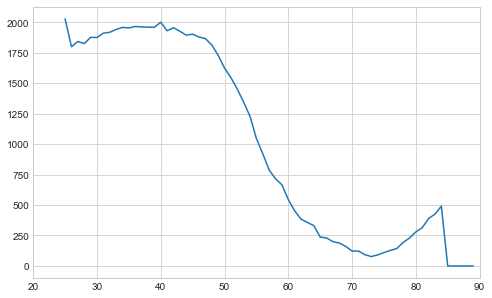

In [40]:
hs = []
step = 1
for i in range(model.par.Tmin, model.par.T, step):
    h = model.sim.h[i, :]
    #print(h)
    #print(h)
    #hh = egm.util( model.sim.m[i, :] , model.sim.h[i, :][0], i, model.par)
    #h = model.sim.h[i, :]
    #print(i)
    h = np.average(h)
    hs.append(h)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(20, model.par.T)
ax.plot(list(range(model.par.Tmin, model.par.T, step)) , hs)

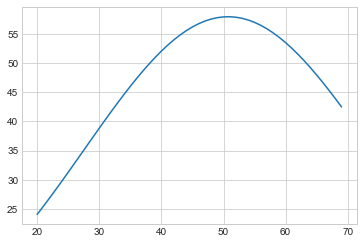

In [9]:
vs = []
ds = []
years = list(range(20, 70))
for i in years:
    ds.append( egm.human_capital(1, i, model.par) )
    vs.append( egm.util_bequest(10*i, model.par, False) )
plt.plot(years, ds)
#plt.plot(vs)

[25, 40, 50, 60, 70, 80]


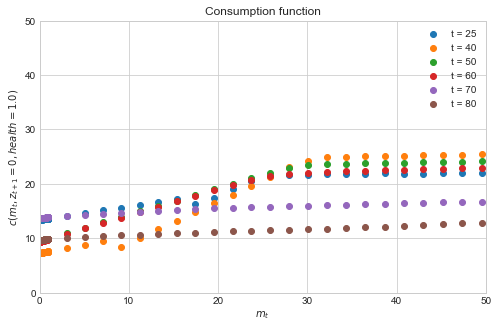

[25, 40, 50, 60, 70, 80]


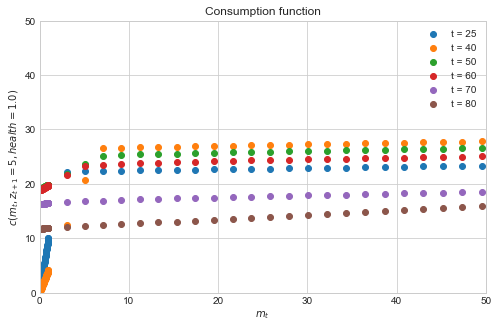

In [10]:
# Figure
def figure_multi_dim(par,sol,T,i_h):
    p = par.grid_e[i_h]

    ts = [25, 40, 50, 60, 70, 80]
    print(ts)
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1,1,1)
    
    for i in ts:
        ax.scatter(par.grid_m,sol.c[i-1,T,:,i_h, 0, 0], label=f't = {i}')
    ax.set_xlabel(f"$m_t$")
    ax.set_ylabel(f"$c(m_t,z_{{t+1}} = {T}, health = {p:.3})$")
    ax.set_xlim([0, 50])
    ax.set_ylim([0,50])
    ax.set_title(f'Consumption function')
    plt.legend()
    plt.show()

figure_multi_dim(model.par,model.sol, 0, 99)
figure_multi_dim(model.par,model.sol, 5, 99)
#figure_multi_dim(model.par,model.sol, 10, 50)
#figure_multi_dim(model.par,model.sol, 30, 50)

In [11]:
egm.util(10, 0, 10, model.par)


7.818293900984182

In [12]:
c = 10
par.zeta = model.par.zeta
print(par.zeta)
((c**(1.0-par.zeta))/(1.0-par.zeta))

0.79488


7.818293900984182

In [13]:
def soft_max(x, y):
    v = 0.1
    return v * np.log(np.exp(x/v) + np.exp(y/v))
soft_max(40,2)

40.0